In [1]:
import pickle
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from tqdm import tqdm
import numpy as np
import h5py
import jax_cosmo as jc
import healpy as hp
from numpyro import distributions as dist
from jax.lib import xla_bridge
import numpyro
from numpyro import sample
from numpyro.handlers import condition, reparam, seed, trace

print(xla_bridge.get_backend().platform)

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu


In [2]:
import pickle
import os

total_steps = 50_000
lr_rate = 1e-2
batch = 49999
           
PATH_experiment = f"{total_steps}_{lr_rate}_new49"

with open(f"./save_params/{PATH_experiment}/params_nd_vae_batch{batch}.pkl", "rb") as fp:
    vae_params = pickle.load(fp)

with open(f"./save_params/{PATH_experiment}/opt_state_vae_batch{batch}.pkl", "rb") as fp:
    opt_state = pickle.load(fp)

with open(f"./save_params/{PATH_experiment}/state_vae_batch{batch}.pkl", "rb") as fp:
    state = pickle.load(fp)

In [3]:
print("######## CONFIG ########")

sigma_e = 0.26
galaxy_density = gal_per_arcmin2 = 10
field_size = map_size = size = 10
field_npix = N = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6
nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area

# Create our fiducial observations
pix_area = (map_size * 60 / N) ** 2  # arcmin2
map_size_rad = map_size / 180 * jnp.pi  # radians

######## CONFIG ########


In [4]:
print("######## OBSERVED DATA ########")

filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['fiducial']
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0']/100,
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T
truth = list(cosmo_parameters[0])
path = '/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_baryonified512.h5'
m_data = h5py.File(path, "r")
m_data = np.array(m_data['kg']['stage3_lensing{}'.format(4)]) + np.array(m_data['ia']['stage3_lensing{}'.format(4)])
proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
m_data = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
m_data = dist.Independent(
            dist.Normal(
                m_data, 
                sigma_e / jnp.sqrt((galaxy_density * (field_size * 60 / field_npix) ** 2))
            ),
            2
        ).sample(jax.random.PRNGKey(0),(1,))

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']

######## OBSERVED DATA ########


In [5]:
Om_sample = tfd.Uniform(0.1,0.5).sample(1000, jax.random.PRNGKey(0))
s8_sample  = tfd.Uniform(0.4,1.4).sample(1000, jax.random.PRNGKey(10))
h_sample = tfd.Uniform(0.64, 0.82).sample(1000, jax.random.PRNGKey(20))
Ob_sample  = tfd.Uniform(0.03,0.06).sample(1000, jax.random.PRNGKey(30))
ns_sample  = tfd.Uniform(0.87, 1.07).sample(1000, jax.random.PRNGKey(40))
w0_sample  = tfd.Uniform(-2.0, -0.333).sample(1000, jax.random.PRNGKey(50))

prior = jnp.array([Om_sample, s8_sample, w0_sample, h_sample, ns_sample, Ob_sample]).T

In [25]:
# print("######## LEARNED MODEL ########")

# def Pk_fn(k, cosmo, a_ai=None):
#     pz = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10 / 4)
#     tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
#     ell_tab = jnp.logspace(0, 4.5, 128)
#     cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
#     return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


# def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
#     k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
#     kcoords = jnp.meshgrid(k, k)
#     k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
#     ps_map = pk_fn(k)
#     ps_map = ps_map.at[0, 0].set(zero_freq_val)
#     return ps_map * (N / field_size) ** 2


# def learned_likelihood(theta, x, z):
    
#     cosmo = jc.Planck15(
#         Omega_c=theta[0] - theta[-1],
#         Omega_b=theta[-1],
#         h=theta[3],
#         n_s=theta[4],
#         sigma8=theta[1],
#         Omega_k=0.0,
#         w0=theta[2],
#         wa=0.0,
#     )
    
#     P = partial(Pk_fn, cosmo=cosmo, a_ai=None)
#     power_map = make_power_map(P, N, map_size)
    
#     gaussian_map = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real

#     out_vae, _ = decoder_eval.apply(vae_params, state[1], gaussian_map)
    
#     return posterior_x(out_vae.squeeze())

In [6]:
from unet_model import UResNet
from collections.abc import Mapping
import haiku as hk

class ConvDecoder(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        
    def __call__(self, x):
        residual = hk.Conv2D(1, 3, 1)(x)
        residual = jax.nn.leaky_relu(residual)
        residual = hk.Conv2D(1, 3, 1)(residual) 
        residual = jax.nn.leaky_relu(residual)
        residual = hk.Conv2D(1, 3, 1)(residual)
        return (residual + x).squeeze()


decoder_eval = hk.without_apply_rng(
    hk.transform_with_state(
        lambda z: ConvDecoder(output_dim=1)(
            z.reshape([-1, N, N, 1])
        )
    )
)

@jax.jit
@jax.vmap
def predicted_nbody(gaussian_map): 
    out_vae, _ =  decoder_eval.apply(vae_params, state[1], gaussian_map.reshape([1, N, N, 1]))
    return out_vae

In [7]:
from jax_cosmo.redshift import redshift_distribution
from jax.tree_util import register_pytree_node_class
import jax.numpy as jnp

@register_pytree_node_class
class smail_nz2(redshift_distribution):
    def pz_fn(self, z):
        a, b, z0 = self.params
        return z**a * jnp.exp(-((z / z0) ** b))*4
    
def Pk_fn(k, cosmo, a_ai=None):
    pz = smail_nz2(3.53, 4.49, 1.03, gals_per_arcmin2=galaxy_density)
    tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    return ps_map * (N / field_size) ** 2

def learned_forward_model():
    Om = numpyro.sample("Om", dist.Uniform(0.1,0.5))
    s8 = numpyro.sample("s8", dist.Uniform(0.4,1.4))
    h = numpyro.sample("h", dist.Uniform(0.64, 0.82))
    Ob = numpyro.sample("Ob", dist.Uniform(0.03,0.06))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
    w0 = numpyro.sample("w0", dist.Uniform(-2.0, -0.333))
    
    z = numpyro.sample(
        "z", dist.MultivariateNormal(loc=jnp.zeros((N, N)), precision_matrix=jnp.eye(N))
    )
    
    cosmo = jc.Planck15(
        Omega_c=Om - Ob,
        Omega_b=Ob,
        h=h,
        n_s=ns,
        sigma8=s8,
        Omega_k=0.0,
        w0=w0,
        wa=0.0,
    )
    
    P = partial(Pk_fn, cosmo=cosmo, a_ai=None)
    power_map = make_power_map(P, N, map_size_rad)
    
    gaussian_map = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real
    gaussian_map = gaussian_map - gaussian_map.mean()

    out_vae = predicted_nbody(gaussian_map.reshape([-1,N,N]))
    
    x = numpyro.sample(
        "x",
        dist.Independent(
            dist.Normal(out_vae.squeeze(), sigma_e / jnp.sqrt(gal_per_arcmin2 * pix_area)), 2
        ),
    )
    
    return x

In [8]:
fiducial_model = numpyro.handlers.condition(
    learned_forward_model, 
    {
        "Om": cosmo_parameters[0][0], 
        "s8": cosmo_parameters[0][1], 
        "w0": cosmo_parameters[0][2], 
        "h": cosmo_parameters[0][3], 
        "ns": cosmo_parameters[0][4],
        "Ob": cosmo_parameters[0][5], 
    }
)
model_trace = numpyro.handlers.trace(seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()

# the fid values to init the mcmc (Which do not corresponds to observed data)
init_values = {
    k: model_trace[k]["value"] for k in ["z", "Om", "s8", "w0", "h", "ns", "Ob"]
}

######### RUN FULL-FIELD MCMC ##########
num_samples = 2000
num_chains = 1
thinning = 5
num_warmup = 300
chain_method = "vectorized"
step_size = 1e-2
max_tree_depth = 5

observed_model = condition(
    learned_forward_model,
    {"x":m_data},
)

# Building the sampling kernel
nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    max_tree_depth=max_tree_depth,
    step_size=step_size,
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    chain_method=chain_method,
    thinning=thinning,
    progress_bar=True,
)

mcmc.run(jax.random.PRNGKey(0), extra_fields=("num_steps",))
samples_ = mcmc.get_samples()
# save only sample of interest
samples_ = jnp.stack(
    [
        samples_['Om'],
        samples_['s8'],
        samples_['w0'],
        samples_['h'],
        samples_['ns'],
        samples_['Ob']
    ],
    axis=-1,
)

/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

In [19]:
samples_init = mcmc.get_samples()

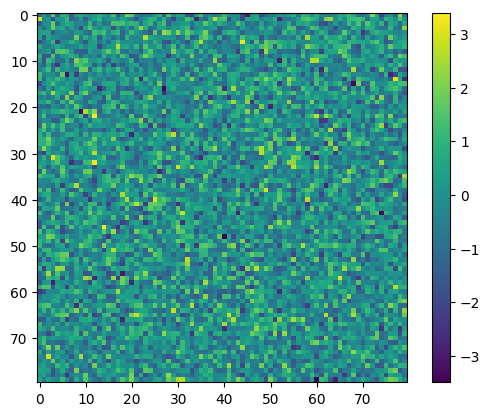

In [24]:
plt.imshow(samples_init['z'][0]); plt.colorbar();

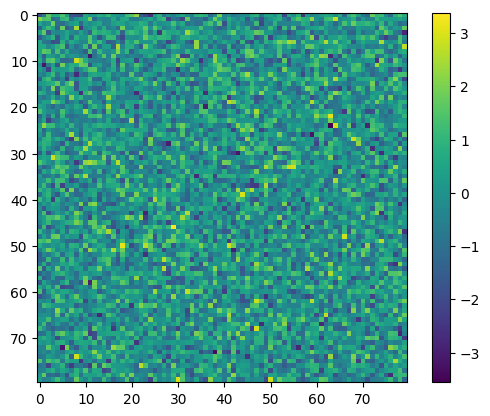

In [25]:
plt.imshow(samples_init['z'][10]); plt.colorbar();

In [17]:
jnp.save('chains', samples_)

In [ ]:
# print("######## DEFINING FUN FOR MCMC ########") 

# def Pk_fn(k, cosmo, a_ai=None):
#     pz = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10 / 4)
#     tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
#     ell_tab = jnp.logspace(0, 4.5, 128)
#     cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
#     return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


# def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
#     k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
#     kcoords = jnp.meshgrid(k, k)
#     k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
#     ps_map = pk_fn(k)
#     ps_map = ps_map.at[0, 0].set(zero_freq_val)
#     return ps_map * (N / field_size) ** 2


# def learned_likelihood(theta, z):
    
#     cosmo = jc.Planck15(
#         Omega_c=theta[0] - theta[-1],
#         Omega_b=theta[-1],
#         h=theta[3],
#         n_s=theta[4],
#         sigma8=theta[1],
#         Omega_k=0.0,
#         w0=theta[2],
#         wa=0.0,
#     )
    
#     P = partial(Pk_fn, cosmo=cosmo, a_ai=None)
#     power_map = make_power_map(P, N, map_size_rad)
    
#     gaussian_map = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real

#     out_vae, _ = decoder_eval.apply(vae_params, state[1], gaussian_map)
#     likelihood = tfd.MultivariateNormalDiag(out_vae.squeeze(),  jnp.ones(N) * sigma_e**2 /(gal_per_arcmin2 * pix_area))

#     return likelihood




# def log_prob_prior(theta):
#     Om_logprob = tfd.Uniform(0.1,0.5).log_prob(theta[0])
#     s8_logprob = tfd.Uniform(0.4,1.4).log_prob(theta[1])
#     h_logprob = tfd.Uniform(0.64, 0.82).log_prob(theta[3])
#     Ob_logprob = tfd.Uniform(0.03,0.06).log_prob(theta[5])
#     ns_logprob = tfd.Uniform(0.87, 1.07).log_prob(theta[4])
#     w0_logprob = tfd.Uniform(-2.0, -0.333).log_prob(theta[2])
#     return Om_logprob + s8_logprob + h_logprob + Ob_logprob + ns_logprob + w0_logprob


# def log_prob_cond_init(z): 
#     return tfd.MultivariateNormalDiag(
#             loc=jnp.zeros((N, N)), scale_diag = jnp.ones(N)
#         ).log_prob(z)

# def log_prob_fn(theta, x, z):
#         return learned_likelihood(theta, z).log_prob(x)

# @jax.jit
# @jax.vmap
# def unnormalized_log_prob(theta, z):

#     prior = log_prob_prior(theta)
    
#     prior_latent = log_prob_cond_init(z)

#     likelihood = log_prob_fn(theta, m_data, z) 

#     return likelihood + prior + prior_latent

In [ ]:
# print("######## RUN MCMC ########") 
# num_results = 2_000
# num_burnin_steps = 400
# num_chains = 10
# key = jax.random.PRNGKey(0)
# initial_theta = jnp.array(truth) * jnp.ones([num_chains, 6])
# initial_z = jnp.zeros([num_chains, N, N])

# # Combine initial states for theta and z into a single tuple for each chain
# initial_state = initial_theta#[initial_theta, initial_z]

# # Initialize the HMC transition kernel.
# adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
#     tfp.mcmc.HamiltonianMonteCarlo(
#         target_log_prob_fn=unnormalized_log_prob,
#         num_leapfrog_steps=3,
#         step_size=1e-2,
#     ),
#     num_adaptation_steps=int(num_burnin_steps * 0.8),
# )

# # Run the chain (with burn-in).
# # @jax.jit
# def run_chain():
#     # Run the chain (with burn-in).
#     samples, is_accepted = tfp.mcmc.sample_chain(
#         num_results=num_results,
#         num_burnin_steps=num_burnin_steps,
#         current_state= initial_state, 
#         kernel=adaptive_hmc,
#         trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
#         seed=key,
#     )

#     return samples, is_accepted

# samples_hmc, is_accepted_hmc = run_chain()
# sample_nd = samples_hmc[is_accepted_hmc]

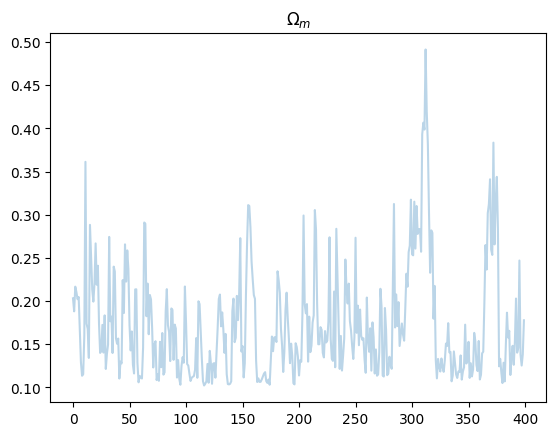

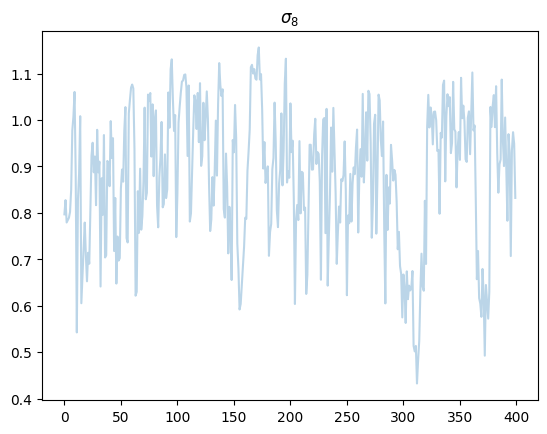

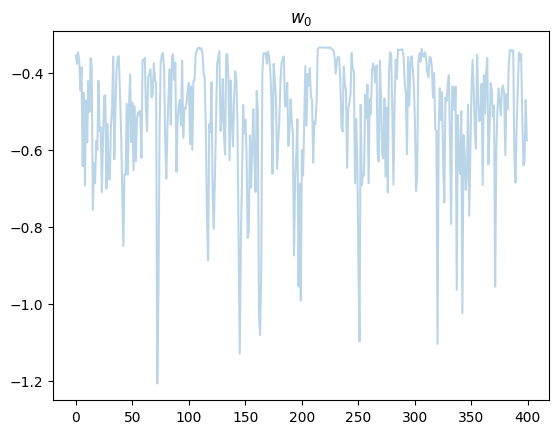

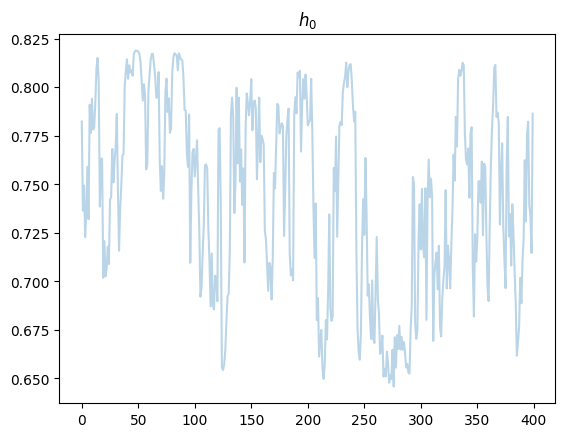

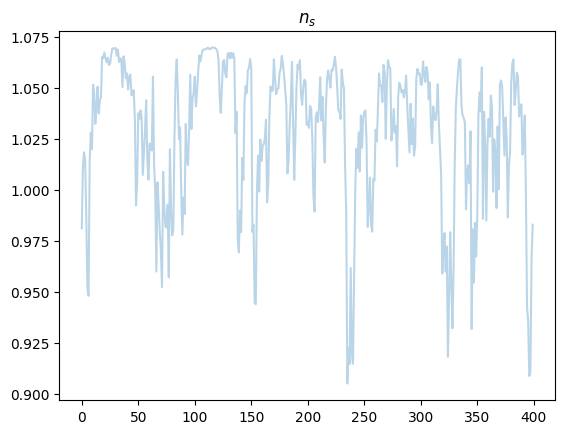

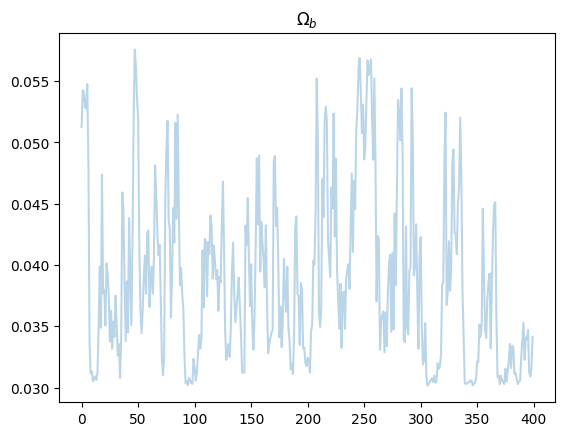

In [10]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']

for i in range(6):
    plt.plot(samples_[:, i], alpha=0.3)
    plt.title(params_name[i])
    plt.show()

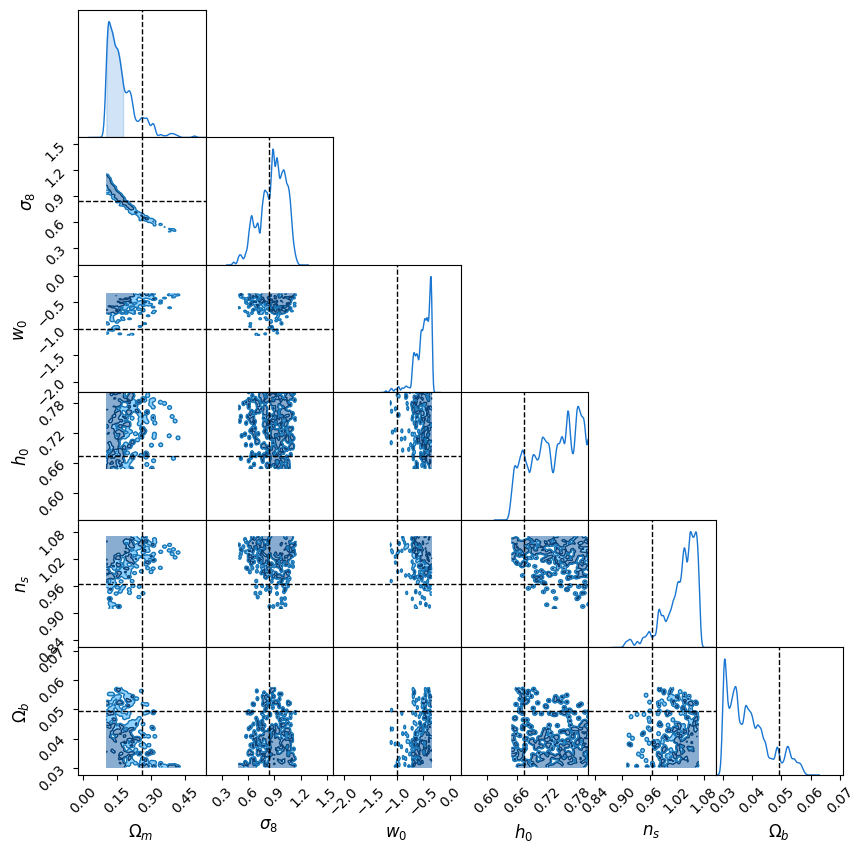

In [11]:
from chainconsumer import ChainConsumer

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
c = ChainConsumer()

c.add_chain(
    samples_,
    shade_alpha = 0.5, 
    parameters = params_name, 
    name = f'learned model'
)

fig = c.plotter.plot(
    figsize=1.,
    truth=truth,
    extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)

In [12]:
posterior_vmim_gaussian = jnp.load('/gpfsdswork/projects/rech/eqw/ufa23yn/dev/PoCLikelihoodInference/sbi/nde_notebooks/posterior_vmim_gaussian.npy')
posterior_vmim_nbody_with_baryon_ia = jnp.load('/gpfsdswork/projects/rech/eqw/ufa23yn/dev/PoCLikelihoodInference/sbi/nde_notebooks/posterior_vmim_nbody_with_baryon_ia.npy')

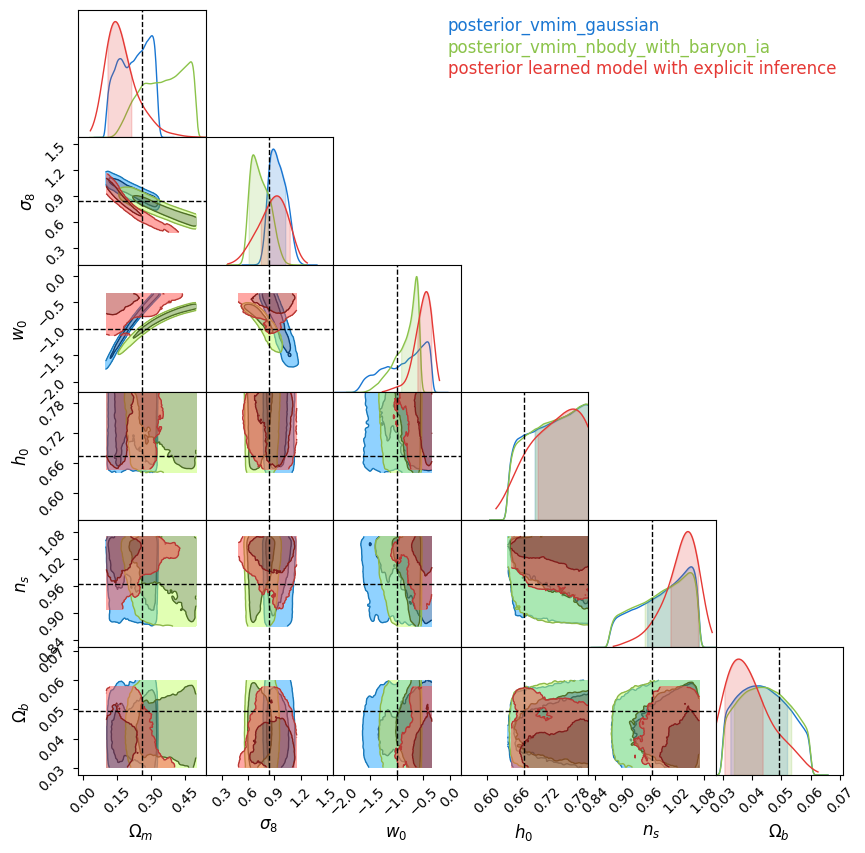

In [13]:
c = ChainConsumer()

c.add_chain(
    posterior_vmim_gaussian,
    shade_alpha = 0.5,
    parameters = params_name,
    name = 'posterior_vmim_gaussian',
)

c.add_chain(
    posterior_vmim_nbody_with_baryon_ia,
    shade_alpha = 0.5,
    parameters = params_name, 
    name = 'posterior_vmim_nbody_with_baryon_ia'
)

c.add_chain(
    samples_,
    shade_alpha = 0.5,
    parameters = params_name,
    name = 'posterior learned model with explicit inference', 
    kde = 1
)

fig = c.plotter.plot(
    figsize=1.,
    truth=truth,
    extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)

In [ ]:
# c = ChainConsumer()

# c.add_chain(
#     posterior_vmim_gaussian,
#     shade_alpha = 0.5,
#     parameters = params_name,
#     name = 'posterior_vmim_gaussian',
# )

# c.add_chain(
#     posterior_vmim_nbody_with_baryon_ia,
#     shade_alpha = 0.5,
#     parameters = params_name, 
#     name = 'posterior_vmim_nbody_with_baryon_ia'
# )

# c.add_chain(
#     samples_,
#     shade_alpha = 0.5,
#     parameters = params_name,
#     name = 'posterior learned model with explicit inference', 
#     kde = 1
# )

# fig = c.plotter.plot(
#     figsize=1.,
#     truth=truth,
#     extents=[[t - 2.5 * np.std(prior[:,i]),
#               t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
# )

In [ ]:
# smail distribution
# training

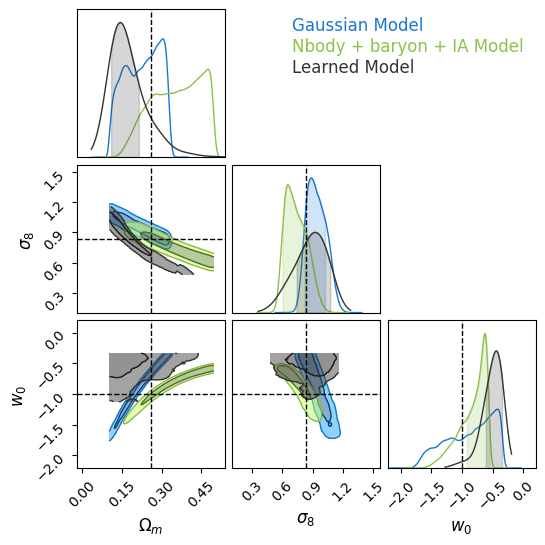

In [14]:
c = ChainConsumer()


c.add_chain(
    posterior_vmim_gaussian[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3],
    name = 'Gaussian Model',
)

c.add_chain(
    posterior_vmim_nbody_with_baryon_ia[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3], 
    name = 'Nbody + baryon + IA Model '
)

c.add_chain(
    samples_[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3],
    name = 'Learned Model', 
    kde = 1,
    color='black'
)

fig = c.plotter.plot(
    figsize=1.2,
    truth=truth[:3],
    extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)

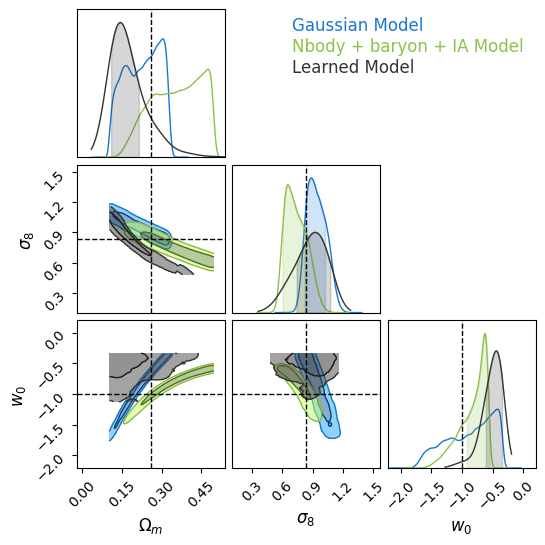

In [18]:
c = ChainConsumer()


c.add_chain(
    posterior_vmim_gaussian[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3],
    name = 'Gaussian Model',
)

c.add_chain(
    posterior_vmim_nbody_with_baryon_ia[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3], 
    name = 'Nbody + baryon + IA Model '
)

c.add_chain(
    samples_[:,:3],
    shade_alpha = 0.5,
    parameters = params_name[:3],
    name = 'Learned Model', 
    kde = 1,
    color='black'
)

fig = c.plotter.plot(
    figsize=1.2,
    truth=truth[:3],
    extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)